<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>


## Waveforms for two different modes close to coastal features ##

As part of Copernicus, EUMETSAT operates the Poseidon-4 altimeter on Sentinel-6.

Waveforms are the fundamental signal that altimeters receive, and from which they derive all their information about the ocean surface. The shape of a waveform is determined by how a radar pulse interacts with the Earth's surface. Much more information on waveforms can be found here:

http://www.altimetry.info/radar-altimetry-tutorial/how-altimetry-works/from-radar-pulse-to-altimetry-measurements/

In [2]:
import os
#import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numpy

In [3]:
#we will look at the plot within the notebooks
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,10)
plt.ioff()
matplotlib.rcParams.update({'font.size': 16})

To help to find your data, please complete the MYPATH variable below with the output generated by the /Configuration_Testing/Data_Path_Checker.ipynb Jupyter notebook in the Configuration_Testing folder. 

In [4]:
# e.g. MYPATH = os.path.join("C:/","Users","me","Desktop")
#MYPATH = os.cwd()
MYPATH = ''

Plot of waveforms in "two dimensions". Power will be color-coded, while axis will be time (index) and samples

In [5]:
input_root = os.path.join(MYPATH,'data')
input_path = ''
#input_file = 'S6A_P4_1B_HR______20220410T013454_20220410T023107_20220522T154619_3373_052_070_035_EUM__REP_NT_F06.measurement.nc'
input_file = 'S6A_P4_1B_LR______20220410T013454_20220410T023107_20220522T101118_3373_052_070_035_EUM__REP_NT_F06.measurement.nc'
resolution = input_file[10:12]

if resolution == 'LR':
    varsamp = 'samples'
else:
    varsamp = 'samples_ov'

#input_file = 'S6A_P4_1B_HR______20220428T003339_20220428T012952_20220523T032126_3373_054_022_011_EUM__REP_NT_F06.measurement.nc'
#input_file = 'S6A_P4_1B_LR______20220428T003339_20220428T012952_20220522T193735_3373_054_022_011_EUM__REP_NT_F06.measurement.nc'
my_file    = os.path.join(input_root,input_path,input_file)
nc = xr.open_dataset(my_file)
nc20ku = xr.open_dataset(my_file, group='data_20/ku')

#hr samples_ov 
#lr samples
samples = nc.variables[varsamp]
lat_20_fulltrack = nc20ku.variables['latitude']
lon_20_fulltrack = nc20ku.variables['longitude']

Extract data only in the lon/lat box searched

In [6]:
# port city of Taher 36.8132°N, 5.8517°E
lon_min = 5.75; lat_min = 36.7; lon_max= 5.95; lat_max = 36.9;
# fort Boyard 46°N, -1.214°E; same track
#lon_min = 360-1.3; lat_min = 45.9; lon_max= 360-1.1; lat_max = 46.1;

subsetnc20ku = nc20ku.sel(time=((lon_20_fulltrack > lon_min) & (lon_20_fulltrack < lon_max) & (lat_20_fulltrack > lat_min) & (lat_20_fulltrack < lat_max)))
nc20ku.close()

lat_20 = subsetnc20ku.variables['latitude']
lon_20 = subsetnc20ku.variables['longitude']
time = subsetnc20ku.variables['time']
waveforms_20hz_ku = subsetnc20ku.variables['power_waveform']

Plot of the track, to have a look at where we are (enlarge the set_extent if you want a broader view)

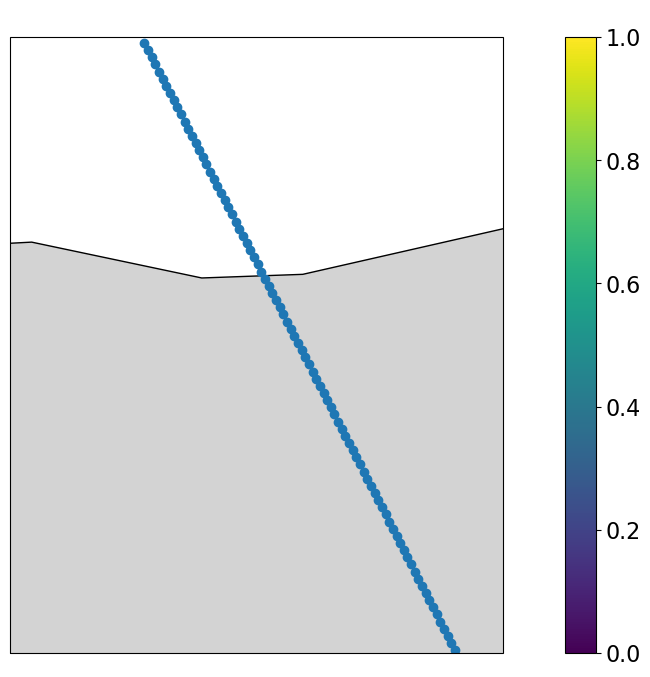

In [7]:
fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
#ax.set_extent([lon_min-5, lon_max+5, lat_min-5, lat_max+5], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=0)
# plot the data on a map
tracks = ax.scatter(lon_20, lat_20)
cbar = plt.colorbar(tracks)
plt.title(' ', size=18)
plt.show()

We will plot the waveforms' power as a color plot along time and samples
Note that we could have used pcolormesh for this and would not have needed the meshgrid regridding, but we will need the scatter plotting afterwards and it would not have worked if the three x, y and c do not have the exact same dimensions. 

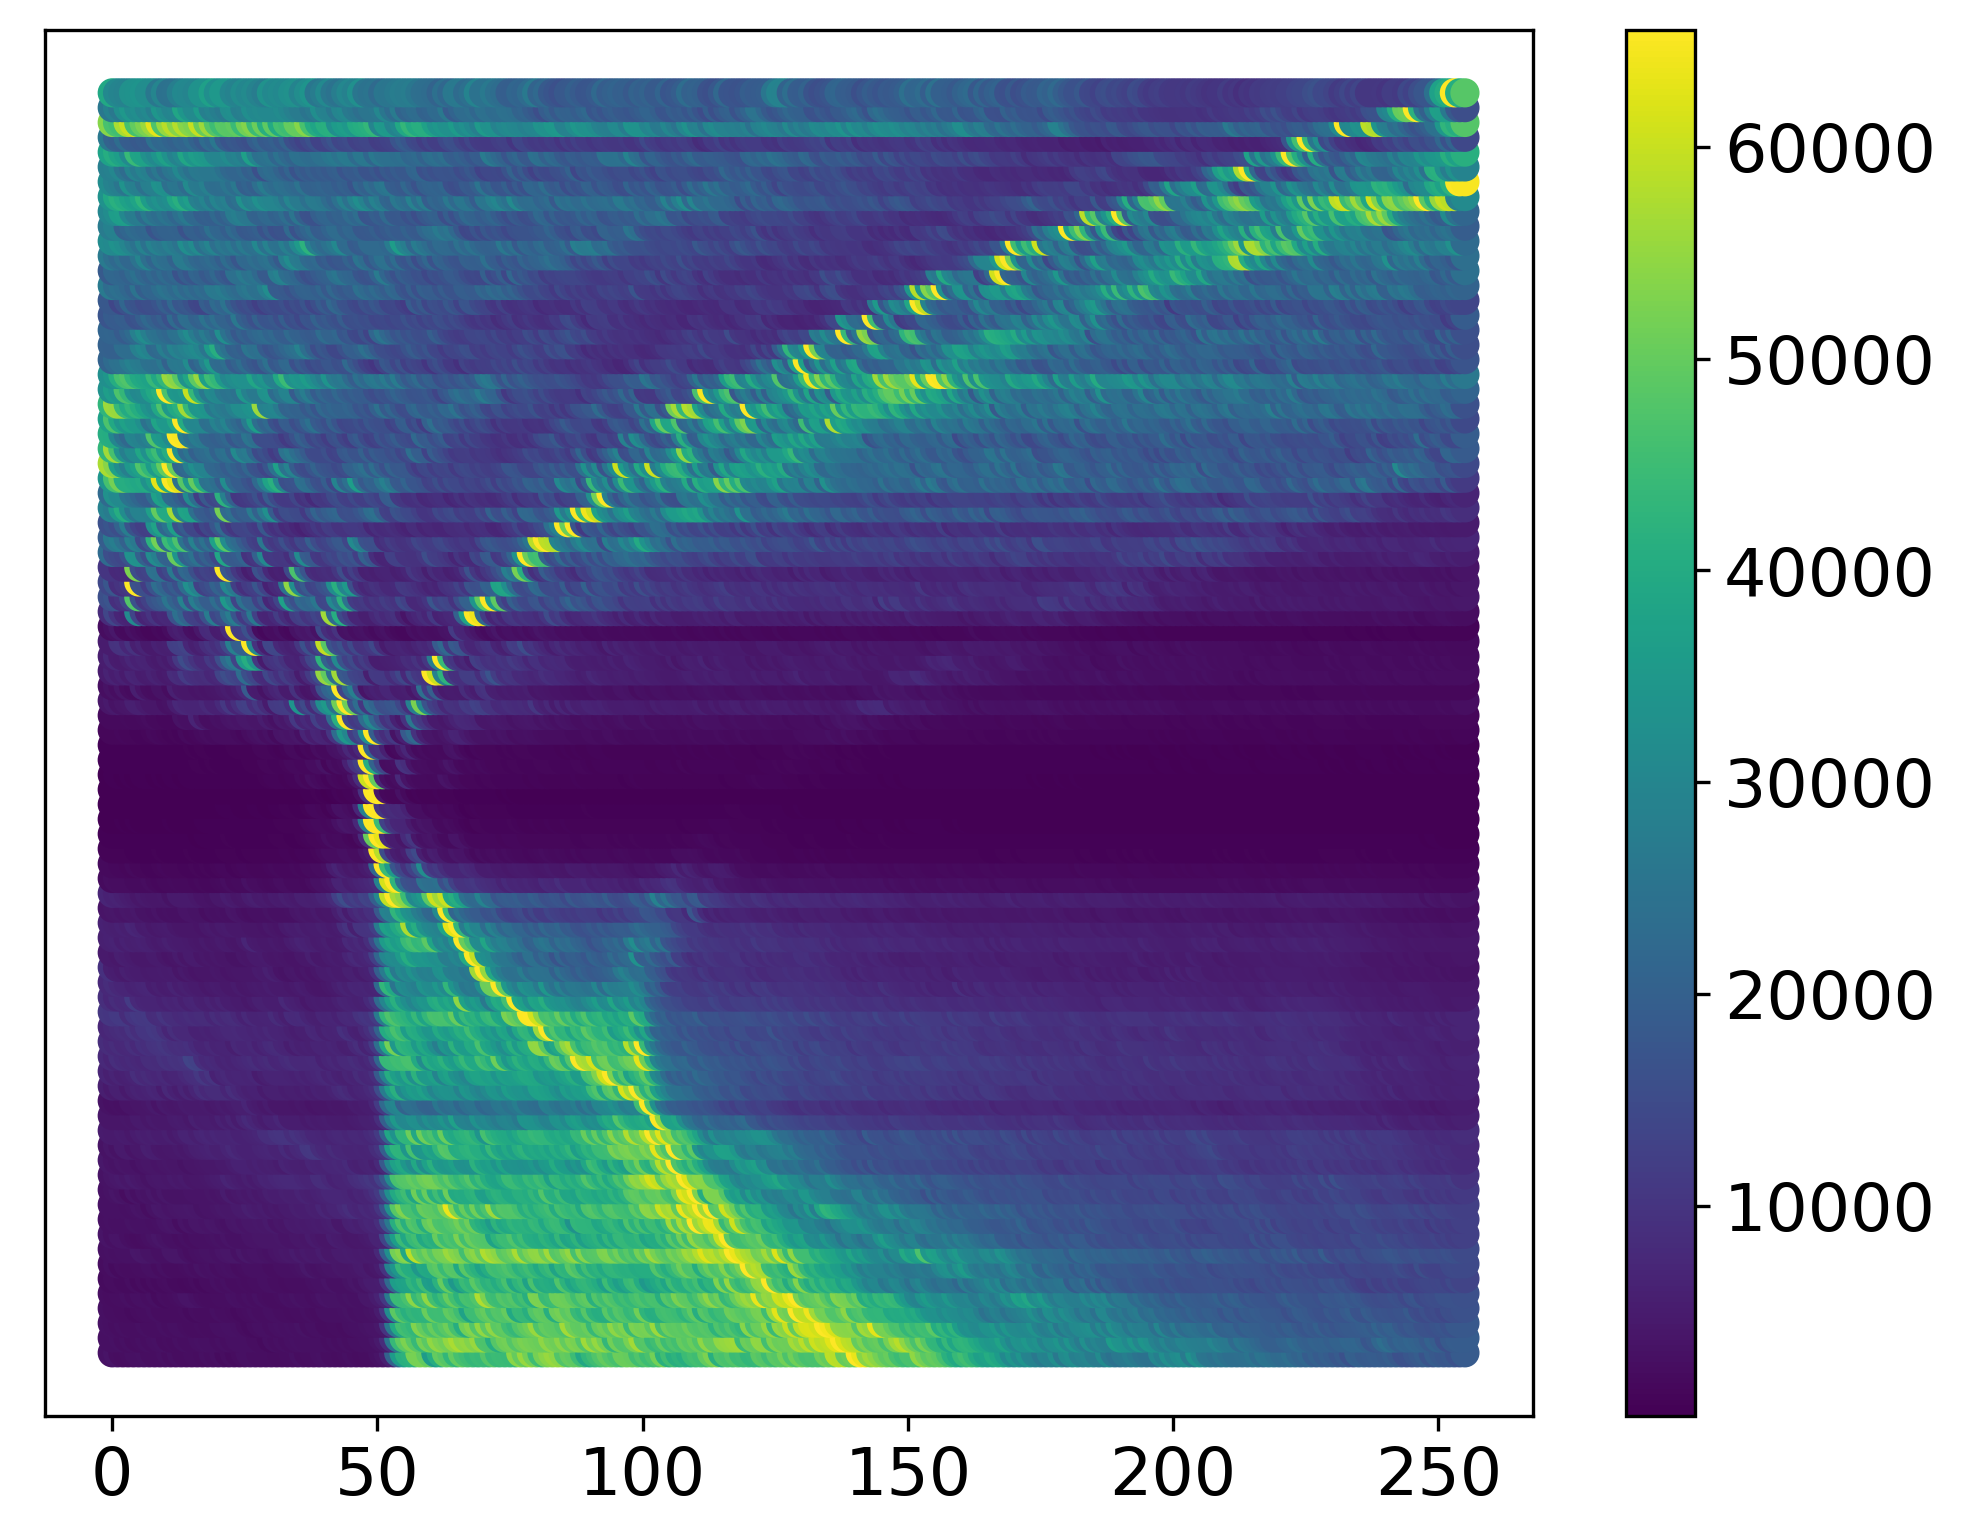

In [8]:
samples2,time2 = numpy.meshgrid(samples,time)

fig = plt.figure(figsize=(8, 6), dpi=300)
ax = plt.subplot(1,1,1)
# useful plot but not fitting our specific need (to overlay this on a map). Most often this is the kind used, though.
p1 = ax.scatter(samples2, time2, c=waveforms_20hz_ku)
#p1 = ax.pcolormesh(waveforms_20hz_ku) # is also working, index vs samples as x and y automatically.

#colorbar
cbar = plt.colorbar(p1)

plt.show()

we need the angle of the track in order to plot the samples across it.

In [9]:
#compute the angle of the track with respect to parallels 
earth_radius = 6371000
track_direction = 0 # checked in advance. in L2 data, 01 group, 'pass_direction_flag' variable
#or check if latitude[i] > latitude[i+1] is True (descending-> 0) or False (ascending-> 1)  
cwin = 2
dLon = numpy.radians(lon_20[cwin:] - lon_20[:-cwin])
dLat = numpy.radians(lat_20[cwin:] - lat_20[:-cwin])
# distance in meters along longitude ending at i (NB. dLon in radians) 
dx_before = earth_radius * dLon * numpy.cos(numpy.radians(lat_20[cwin:]))
# distance in meters along latitude, between i+1 and i (NB. dLat in radians)
dy = earth_radius * dLat

# angle relative to the equator; 
# it depends if the track is ascending (from South pole to North, latitudes increasing) or descending (from North to South)
if track_direction > 0:
    angle = numpy.arctan2(dy, dx_before)
else:
    angle = numpy.arctan2(dy, dx_before) + numpy.pi

# angle has 2 points less than the lat_20 & lon_20 array - we add indexes so as to be able to use them together, 
# even if last two points won't have a valid "angle" value
angle = angle.pad(time=(0,cwin))


Now we (arbitrarilly) define a step in lon, lat between two samples 
Samples are not geolocalised. They are the effect of the radar wave reflection along time, not across the track, but we want to have a look at the waveforms in their geographical context, so we are cheating.

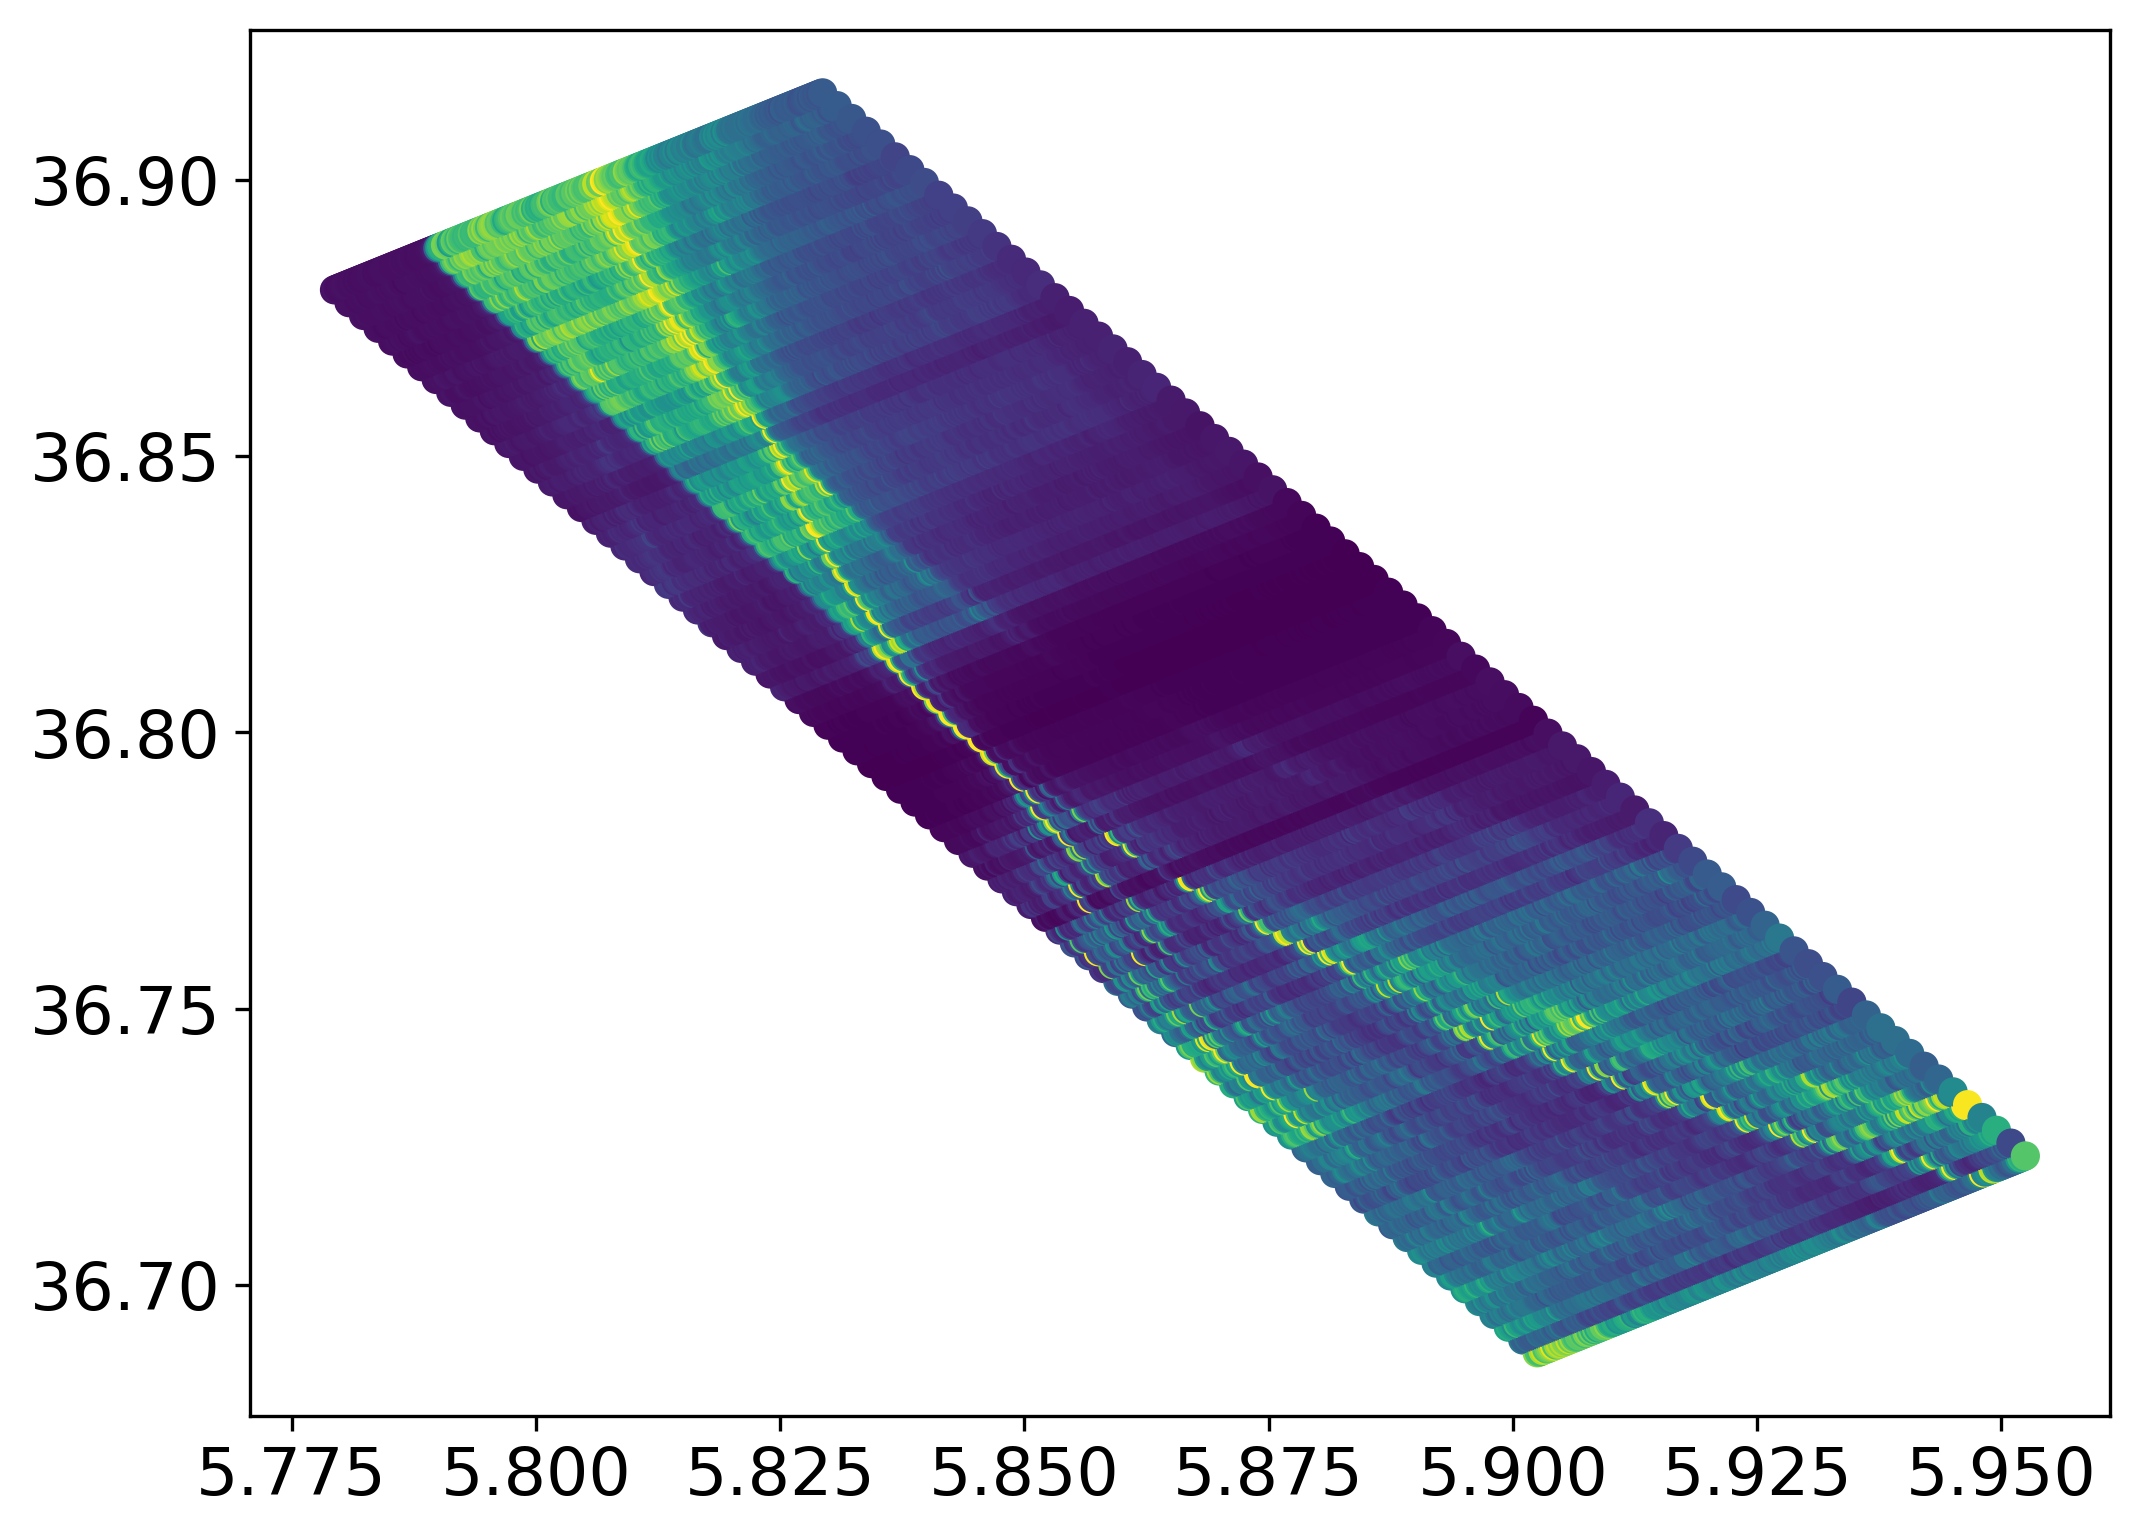

In [10]:
# we place the 128 index at lon_20[t], lat_20[t] to have the middle of our plot on the actual track (purely cosmetic)
# we plot the samples column by column, computing x and y with a tilt (angle computed, coefficients empirical)
# 1 increment ~ 0.05° 
fig = plt.figure(figsize=(8, 6), dpi=300)
ax = plt.subplot(1,1,1)

for i in range(0,256):
#    x = lon_20 - (128-i)*0.0005*numpy.cos(numpy.radians(angle))
#    y = lat_20 - (128-i)*0.0005*numpy.sin(numpy.radians(angle))
    x = lon_20 - ((128-i)/255)*0.05*numpy.cos(numpy.radians(angle))
    y = lat_20 - ((128-i)/255)*numpy.sin(numpy.radians(angle))

    p1 = ax.scatter(x, y, c=waveforms_20hz_ku[:,i], vmin=0., vmax=65534)

#plt.axis('equal')
plt.show()

Plot this on a basic map - note that this is definitely *_not_* a real representation of the width of the radar beam.

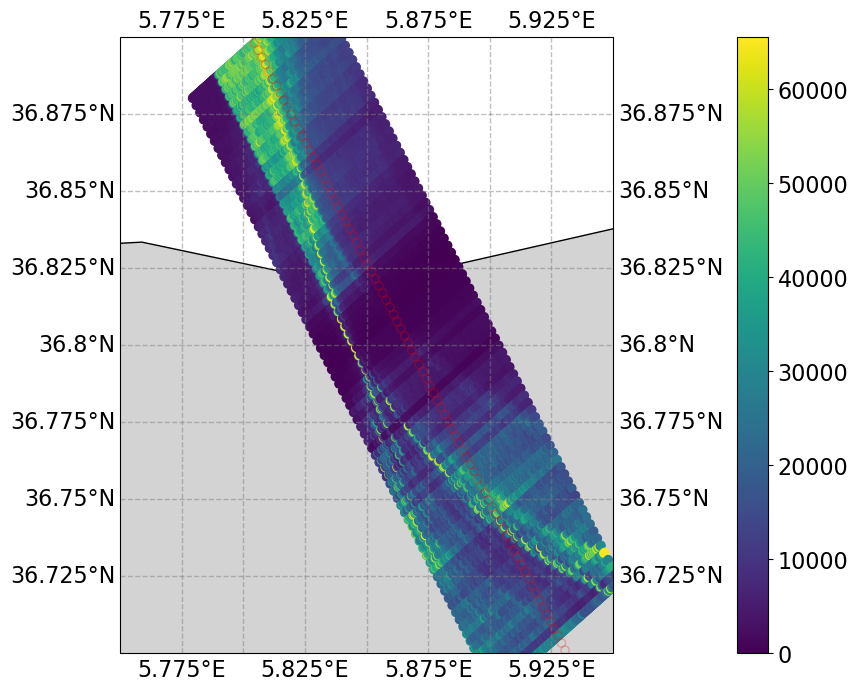

In [11]:
fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, linewidth=1, facecolor='lightgrey', edgecolor='k', zorder=1)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

for i in range(0,256):
    x = lon_20 - ((128-i)/255)*0.05*numpy.cos(numpy.radians(angle))
    y = lat_20 - ((128-i)/255)*numpy.sin(numpy.radians(angle))

    p1 = ax.scatter(x, y, c=waveforms_20hz_ku[:,i], vmin=0., vmax=65534)

#plot the actual track
p2 = ax.scatter(lon_20, lat_20, edgecolors='red', alpha=0.25, c='None')
cbar = plt.colorbar(p1, ax=ax, pad=0.1)
#plt.title('title', size=18)
plt.show()


Plot the same on a high-resolution tiled background map
(NB at high zoom factors, there are no tiles over the ocean, hence possible http errors 404 and white ocean patches)

HTTP Error 404: Not FoundHTTP Error 404: Not Found

HTTP Error 404: Not Found


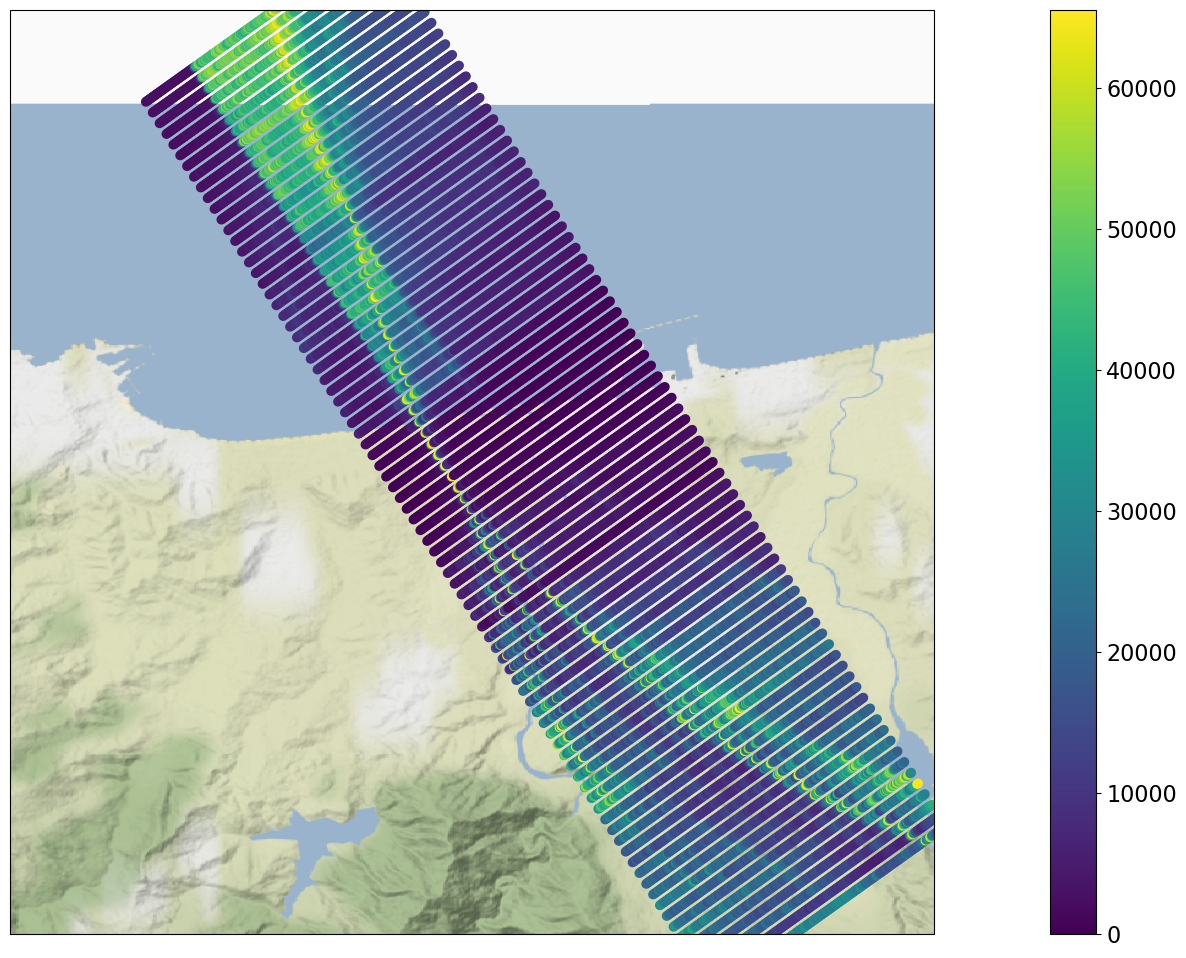

In [12]:
import cartopy.io.img_tiles as cimgt

fig = plt.figure(figsize=(30,12))
ax = plt.axes(projection=ccrs.PlateCarree(), aspect=1.25)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
tiler = cimgt.Stamen('terrain-background')
zoom = 12
ax.add_image(tiler, zoom)

for i in range(0,256):
    x = lon_20 - ((128-i)/255)*0.05*numpy.cos(numpy.radians(angle))
    y = lat_20 - ((128-i)/255)*numpy.sin(numpy.radians(angle))
    p1 = ax.scatter(x, y, c=waveforms_20hz_ku[:,i], vmin=0., vmax=65534)

cbar = plt.colorbar(p1)
plt.savefig('S6_'+resolution+'_waveforms-geographic.png')
plt.show()
